# Projeto do Aluno - Projeto Integrador 3

## O Problema de Negócio:

### Desafio de Ciência de Dados:  Segmentação de Clientes para Maximização de Receita

- Cenário:

A empresa fictícia "RetailX" é uma varejista de grande porte que comercializa 
produtos em diversas categorias para uma ampla base de clientes. 

A empresa busca entender melhor o comportamento de compra dos seus clientes e 
desenvolver estratégias personalizadas para aumentar a fidelização e a receita.
Atualmente, a RetailX enfrenta desafios como:

1) Falta de personalização: As campanhas de marketing são genéricas, não 
levando em consideração o perfil de compra dos clientes.

2) Baixa retenção de clientes: Muitos clientes compram uma vez e não 
retornam.

3) Uso ineficiente dos recursos: O orçamento de marketing é aplicado sem 
critério específico para diferentes segmentos.

- Objetivo do Projeto:

Desenvolver um modelo de segmentação de clientes com base nos dados 
disponíveis, permitindo que a RetailX compreenda os diferentes perfis de 
compra e crie estratégias personalizadas para cada segmento.

## Imports:

In [36]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import umap.umap_ as umap
from matplotlib import pyplot as plt
from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics as mt
from sklearn import cluster as c
from sklearn import mixture as mx 
from sklearn import decomposition as dd
from sklearn import manifold as mn

pd.set_option('display.max_columns', None)

## Load Dataset:

In [2]:
df_customer = pd.read_csv('..\data\clustering_customer.csv')
df_features = pd.read_csv('..\data\clustering_features.csv')

df_raw = df_features.merge(df_customer[['customer_id', 'age', 'hh_income']], on = 'customer_id', how  = 'left')

df_raw.head()

,customer_id,sales,units,orders,unique_products_bought,unique_payments_used,unique_categories_bought,aov,aur,upt,category_a_sales,category_b_sales,category_c_sales,category_d_sales,category_e_sales,category_a_units,category_b_units,category_c_units,category_d_units,category_e_units,payment_cash,payment_credit,payment_debit,payment_gc,payment_others,email_subscribed,omni_shopper,age,hh_income
0,1,2395,11,5,5,3,3,479.000000,217.727273,2.200000,0.480167,NaN,0.450939,NaN,0.068894,0.363636,NaN,0.363636,NaN,0.272727,NaN,0.519833,0.167015,0.313152,NaN,0,0,46,640000
1,2,4815,15,7,6,4,3,687.857143,321.000000,2.142857,0.721703,NaN,0.247144,NaN,0.031153,0.466667,NaN,0.333333,NaN,0.200000,0.031153,0.704050,0.186916,0.077882,NaN,1,1,32,890000
2,3,4285,21,10,9,4,5,428.500000,204.047619,2.100000,0.240373,0.175029,0.309218,0.210035,0.065344,0.190476,0.238095,0.238095,0.095238,0.238095,NaN,0.263711,0.309218,0.147025,0.280047,0,0,45,772000
3,4,12000,44,21,15,4,5,571.428571,272.727273,2.095238,0.575000,0.067500,0.158333,0.170833,0.028333,0.409091,0.159091,0.181818,0.113636,0.136364,0.066667,0.345000,0.370000,0.218333,NaN,1,0,46,303000
4,5,1700,8,3,3,2,2,566.666667,212.500000,2.666667,NaN,0.264706,0.735294,NaN,NaN,NaN,0.375000,0.625000,NaN,NaN,NaN,NaN,0.735294,0.264706,NaN,0,0,38,412000


## 1.0 Descrição dos Dados

In [3]:
df_raw.shape

(1000, 29)

### 1.1 Tipo dos Dados

In [4]:
df_raw.dtypes

customer_id                   int64
sales                         int64
units                         int64
orders                        int64
unique_products_bought        int64
unique_payments_used          int64
unique_categories_bought      int64
aov                         float64
aur                         float64
upt                         float64
category_a_sales            float64
category_b_sales            float64
category_c_sales            float64
category_d_sales            float64
category_e_sales            float64
category_a_units            float64
category_b_units            float64
category_c_units            float64
category_d_units            float64
category_e_units            float64
payment_cash                float64
payment_credit              float64
payment_debit               float64
payment_gc                  float64
payment_others              float64
email_subscribed              int64
omni_shopper                  int64
age                         

### 1.2 Check NA

In [5]:
df_raw.isna().sum()

customer_id                   0
sales                         0
units                         0
orders                        0
unique_products_bought        0
unique_payments_used          0
unique_categories_bought      0
aov                           0
aur                           0
upt                           0
category_a_sales             89
category_b_sales            246
category_c_sales            171
category_d_sales            322
category_e_sales            329
category_a_units             89
category_b_units            246
category_c_units            171
category_d_units            322
category_e_units            329
payment_cash                737
payment_credit               19
payment_debit               129
payment_gc                  366
payment_others              744
email_subscribed              0
omni_shopper                  0
age                           0
hh_income                     0
dtype: int64

In [6]:
#As colunas nulas aparecem quando o cliente não comprou todas as categorias de produtos ou quando não usou todos os tipos de pagamentos.

df_raw.fillna(0, inplace = True)

### 1.3 Estatística Descritiva

In [7]:
#medidas de tendência central:

ct1 = pd.DataFrame(df_raw.apply(np.mean)).T     #média
ct2 = pd.DataFrame(df_raw.apply(np.median)).T   #mediana

#medidas de dispersão:
d1 = pd.DataFrame(df_raw.apply(np.std)).T                               #desvio-padrão
d2 = pd.DataFrame(df_raw.apply(min)).T                                  #mínimo
d3 = pd.DataFrame(df_raw.apply(max)).T                                  #máximo
d4 = pd.DataFrame(df_raw.apply(lambda x: x.max() - x.min())).T          #range
d5 = pd.DataFrame(df_raw.apply(lambda x: x.skew())).T                   #assimetria
d6 = pd.DataFrame(df_raw.apply(lambda x: x.kurtosis())).T               #curtose

#concatenar:
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,customer_id,1.0,1000.000000,999.000000,500.500000,500.500000,288.674990,0.000000,-1.200000
1,sales,330.0,17635.000000,17305.000000,5707.170000,4280.000000,4034.061315,1.035801,-0.113166
2,units,3.0,58.000000,55.000000,21.108000,16.000000,14.401192,1.010319,-0.406009
3,orders,3.0,24.000000,21.000000,9.811000,8.000000,6.381793,1.004636,-0.522280
4,unique_products_bought,2.0,18.000000,16.000000,7.547000,6.000000,3.848609,0.832534,-0.442693
5,unique_payments_used,1.0,5.000000,4.000000,3.005000,3.000000,0.948143,0.194477,-0.537319
6,unique_categories_bought,1.0,5.000000,4.000000,3.843000,4.000000,1.014076,-0.419469,-0.794667
7,aov,110.0,1202.500000,1092.500000,575.336384,568.444444,165.658376,0.459347,0.958188
8,aur,60.0,485.000000,425.000000,271.150530,268.178138,65.908516,0.143837,0.487245
9,upt,1.0,3.666667,2.666667,2.124689,2.139610,0.343835,0.189828,1.010513


## 2.0 MindMap de Hipóteses

In [8]:
df2 = df_raw.copy()

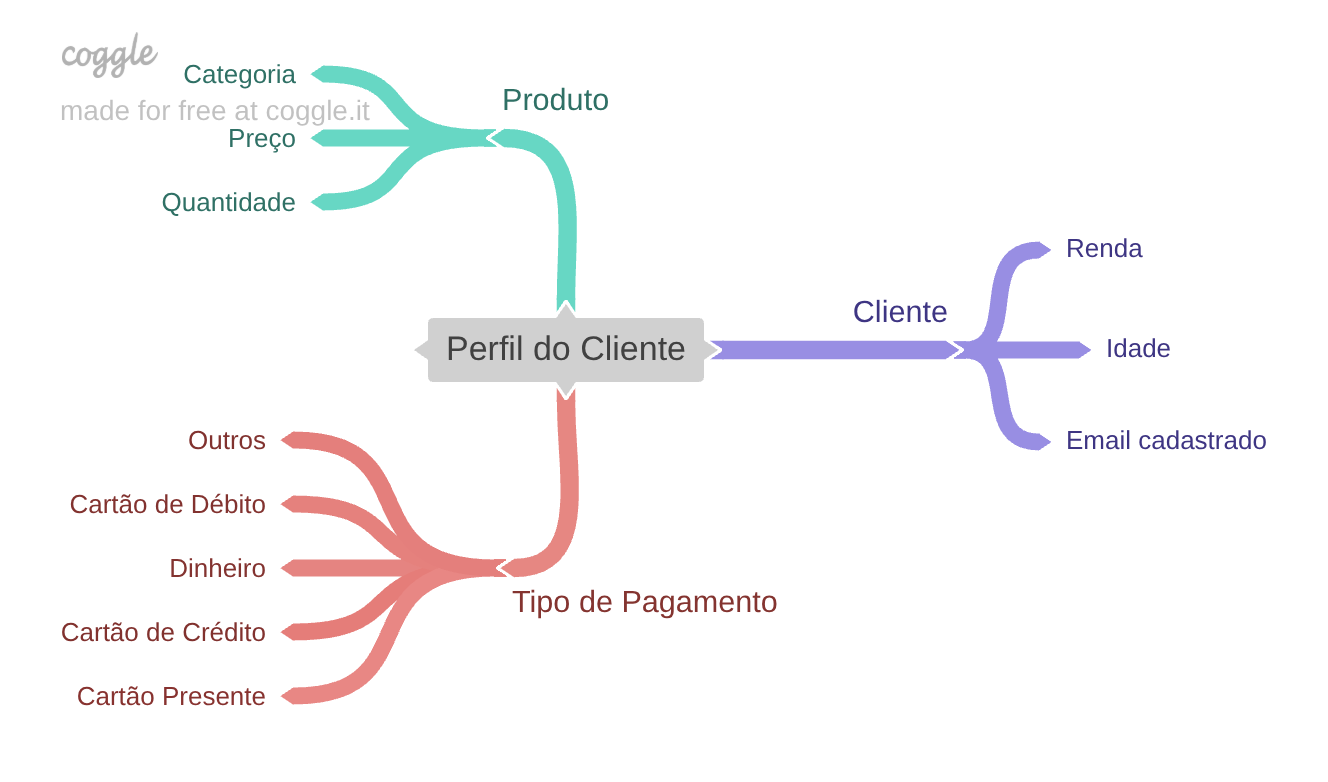

In [9]:
Image('Perfil_do_Cliente.png')

## 3.0 Análise Exploratória dos Dados

In [10]:
df3 = df2.copy()

### 3.1 Análise Univariada

In [11]:
df3.columns

Index(['customer_id', 'sales', 'units', 'orders', 'unique_products_bought',
       'unique_payments_used', 'unique_categories_bought', 'aov', 'aur', 'upt',
       'category_a_sales', 'category_b_sales', 'category_c_sales',
       'category_d_sales', 'category_e_sales', 'category_a_units',
       'category_b_units', 'category_c_units', 'category_d_units',
       'category_e_units', 'payment_cash', 'payment_credit', 'payment_debit',
       'payment_gc', 'payment_others', 'email_subscribed', 'omni_shopper',
       'age', 'hh_income'],
      dtype='object')

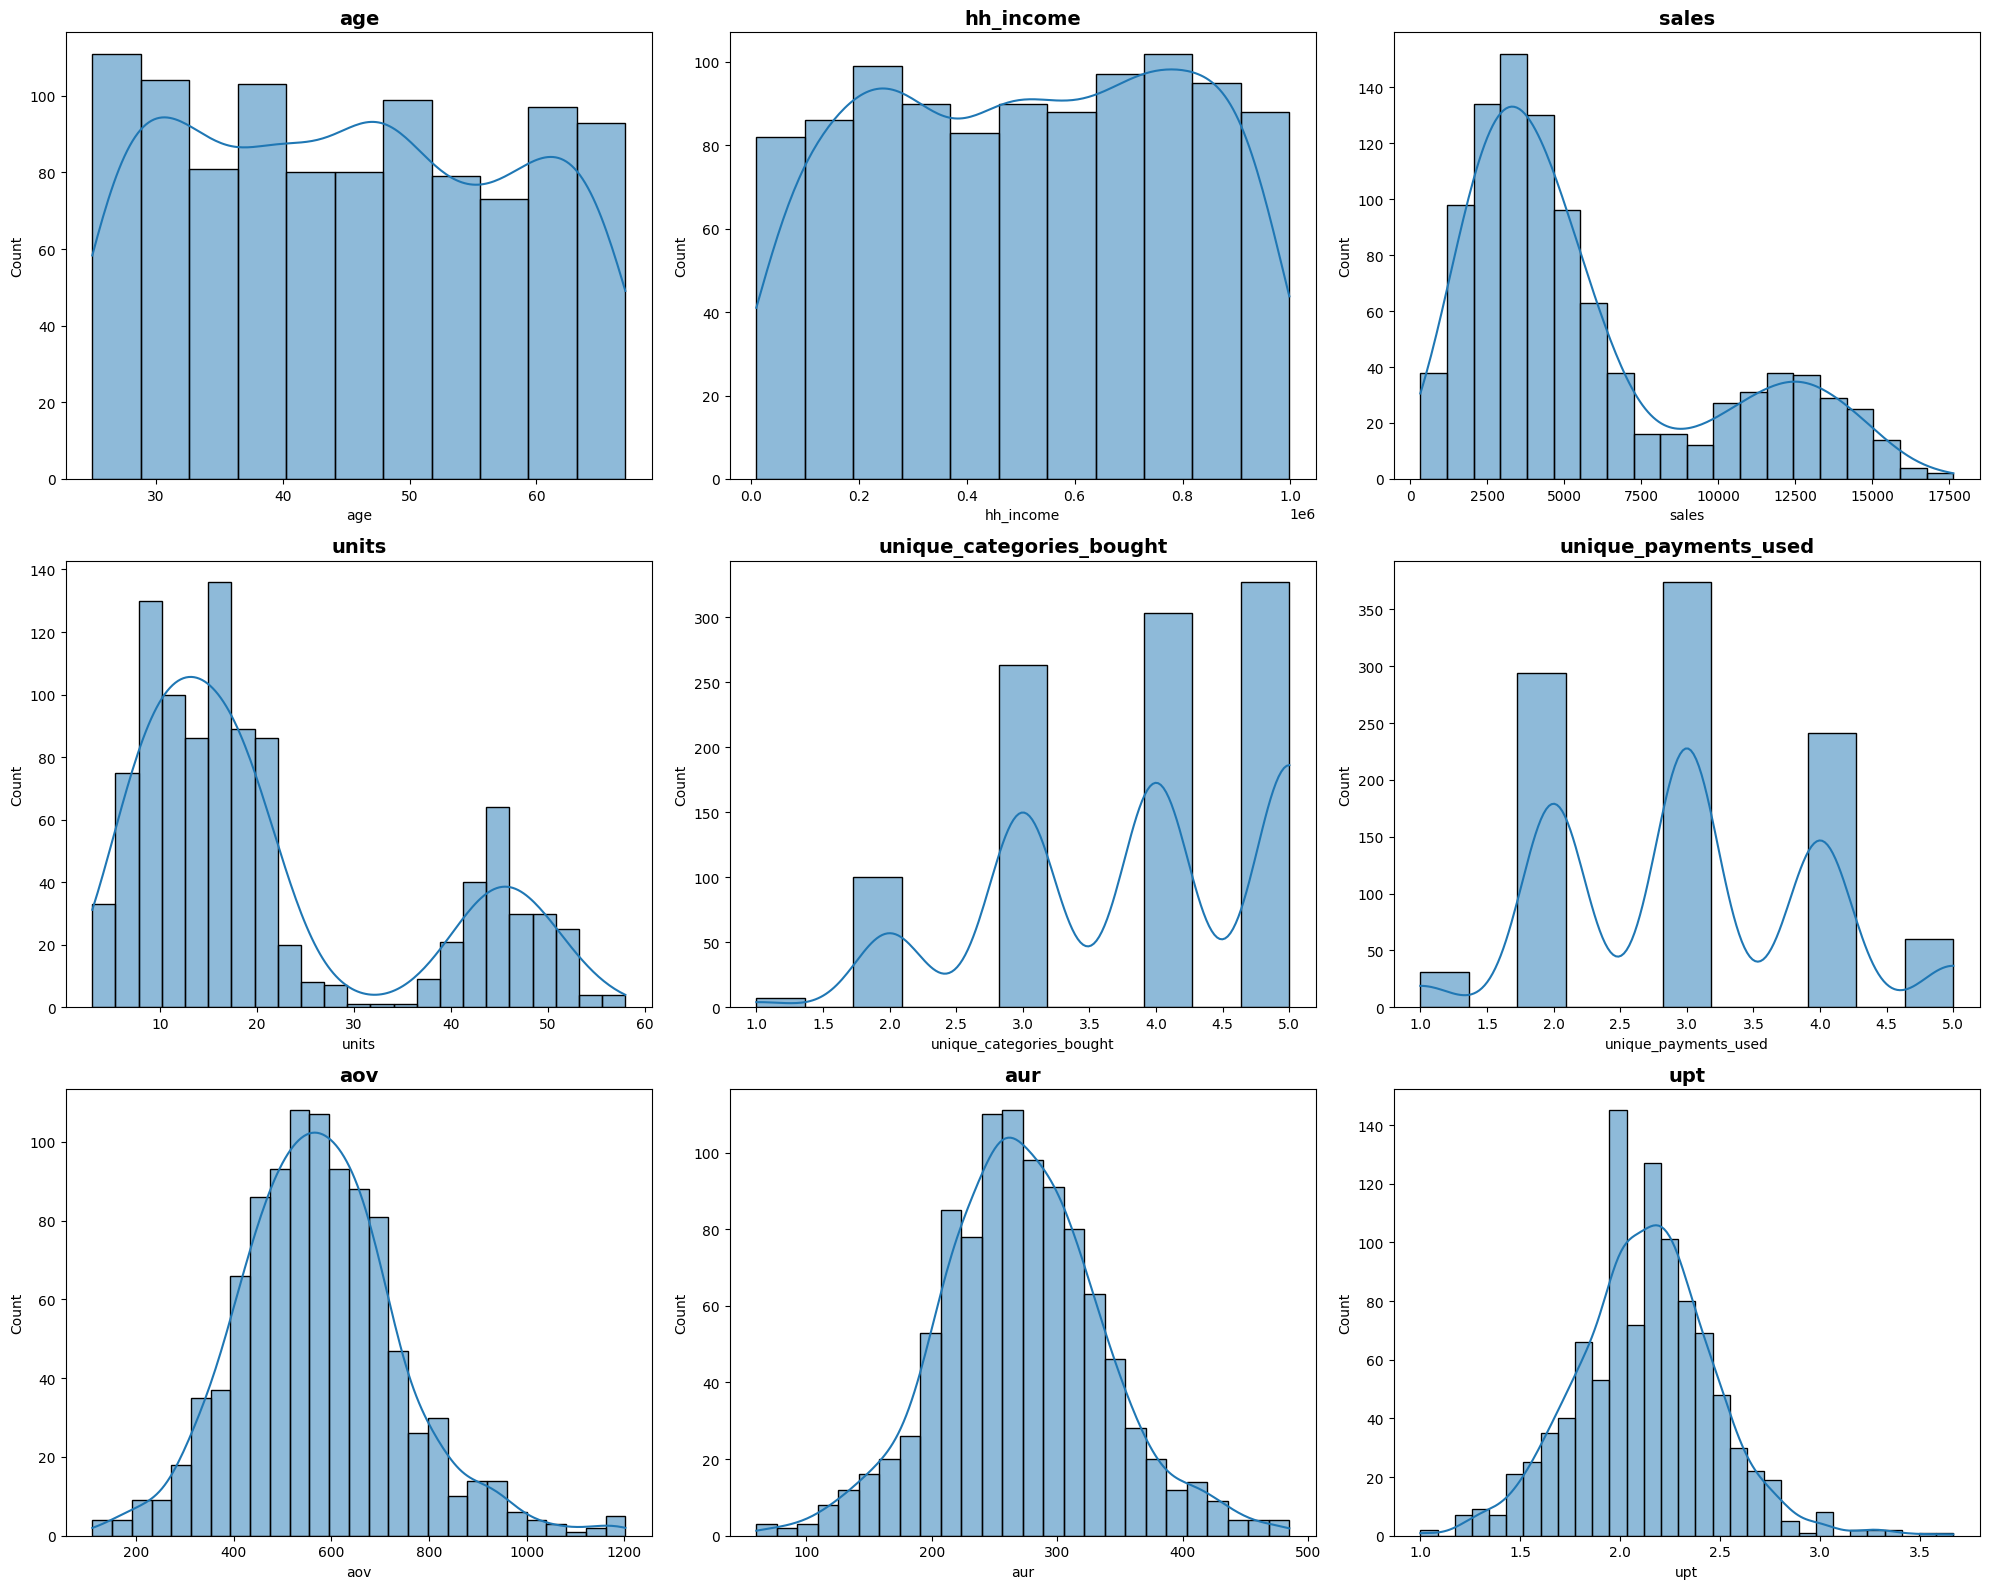

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(20, 16))

columns = ['age', 'hh_income', 'sales', 'units', 'unique_categories_bought',
           'unique_payments_used', 'aov', 'aur', 'upt']

# Achata a matriz de eixos para uma lista 1D
axes = axes.ravel()

for ax, col in zip(axes, columns):
    sns.histplot(df3[col], kde=True, ax=ax)
    ax.set_title(col, fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### 3.2 Análise Bivariada

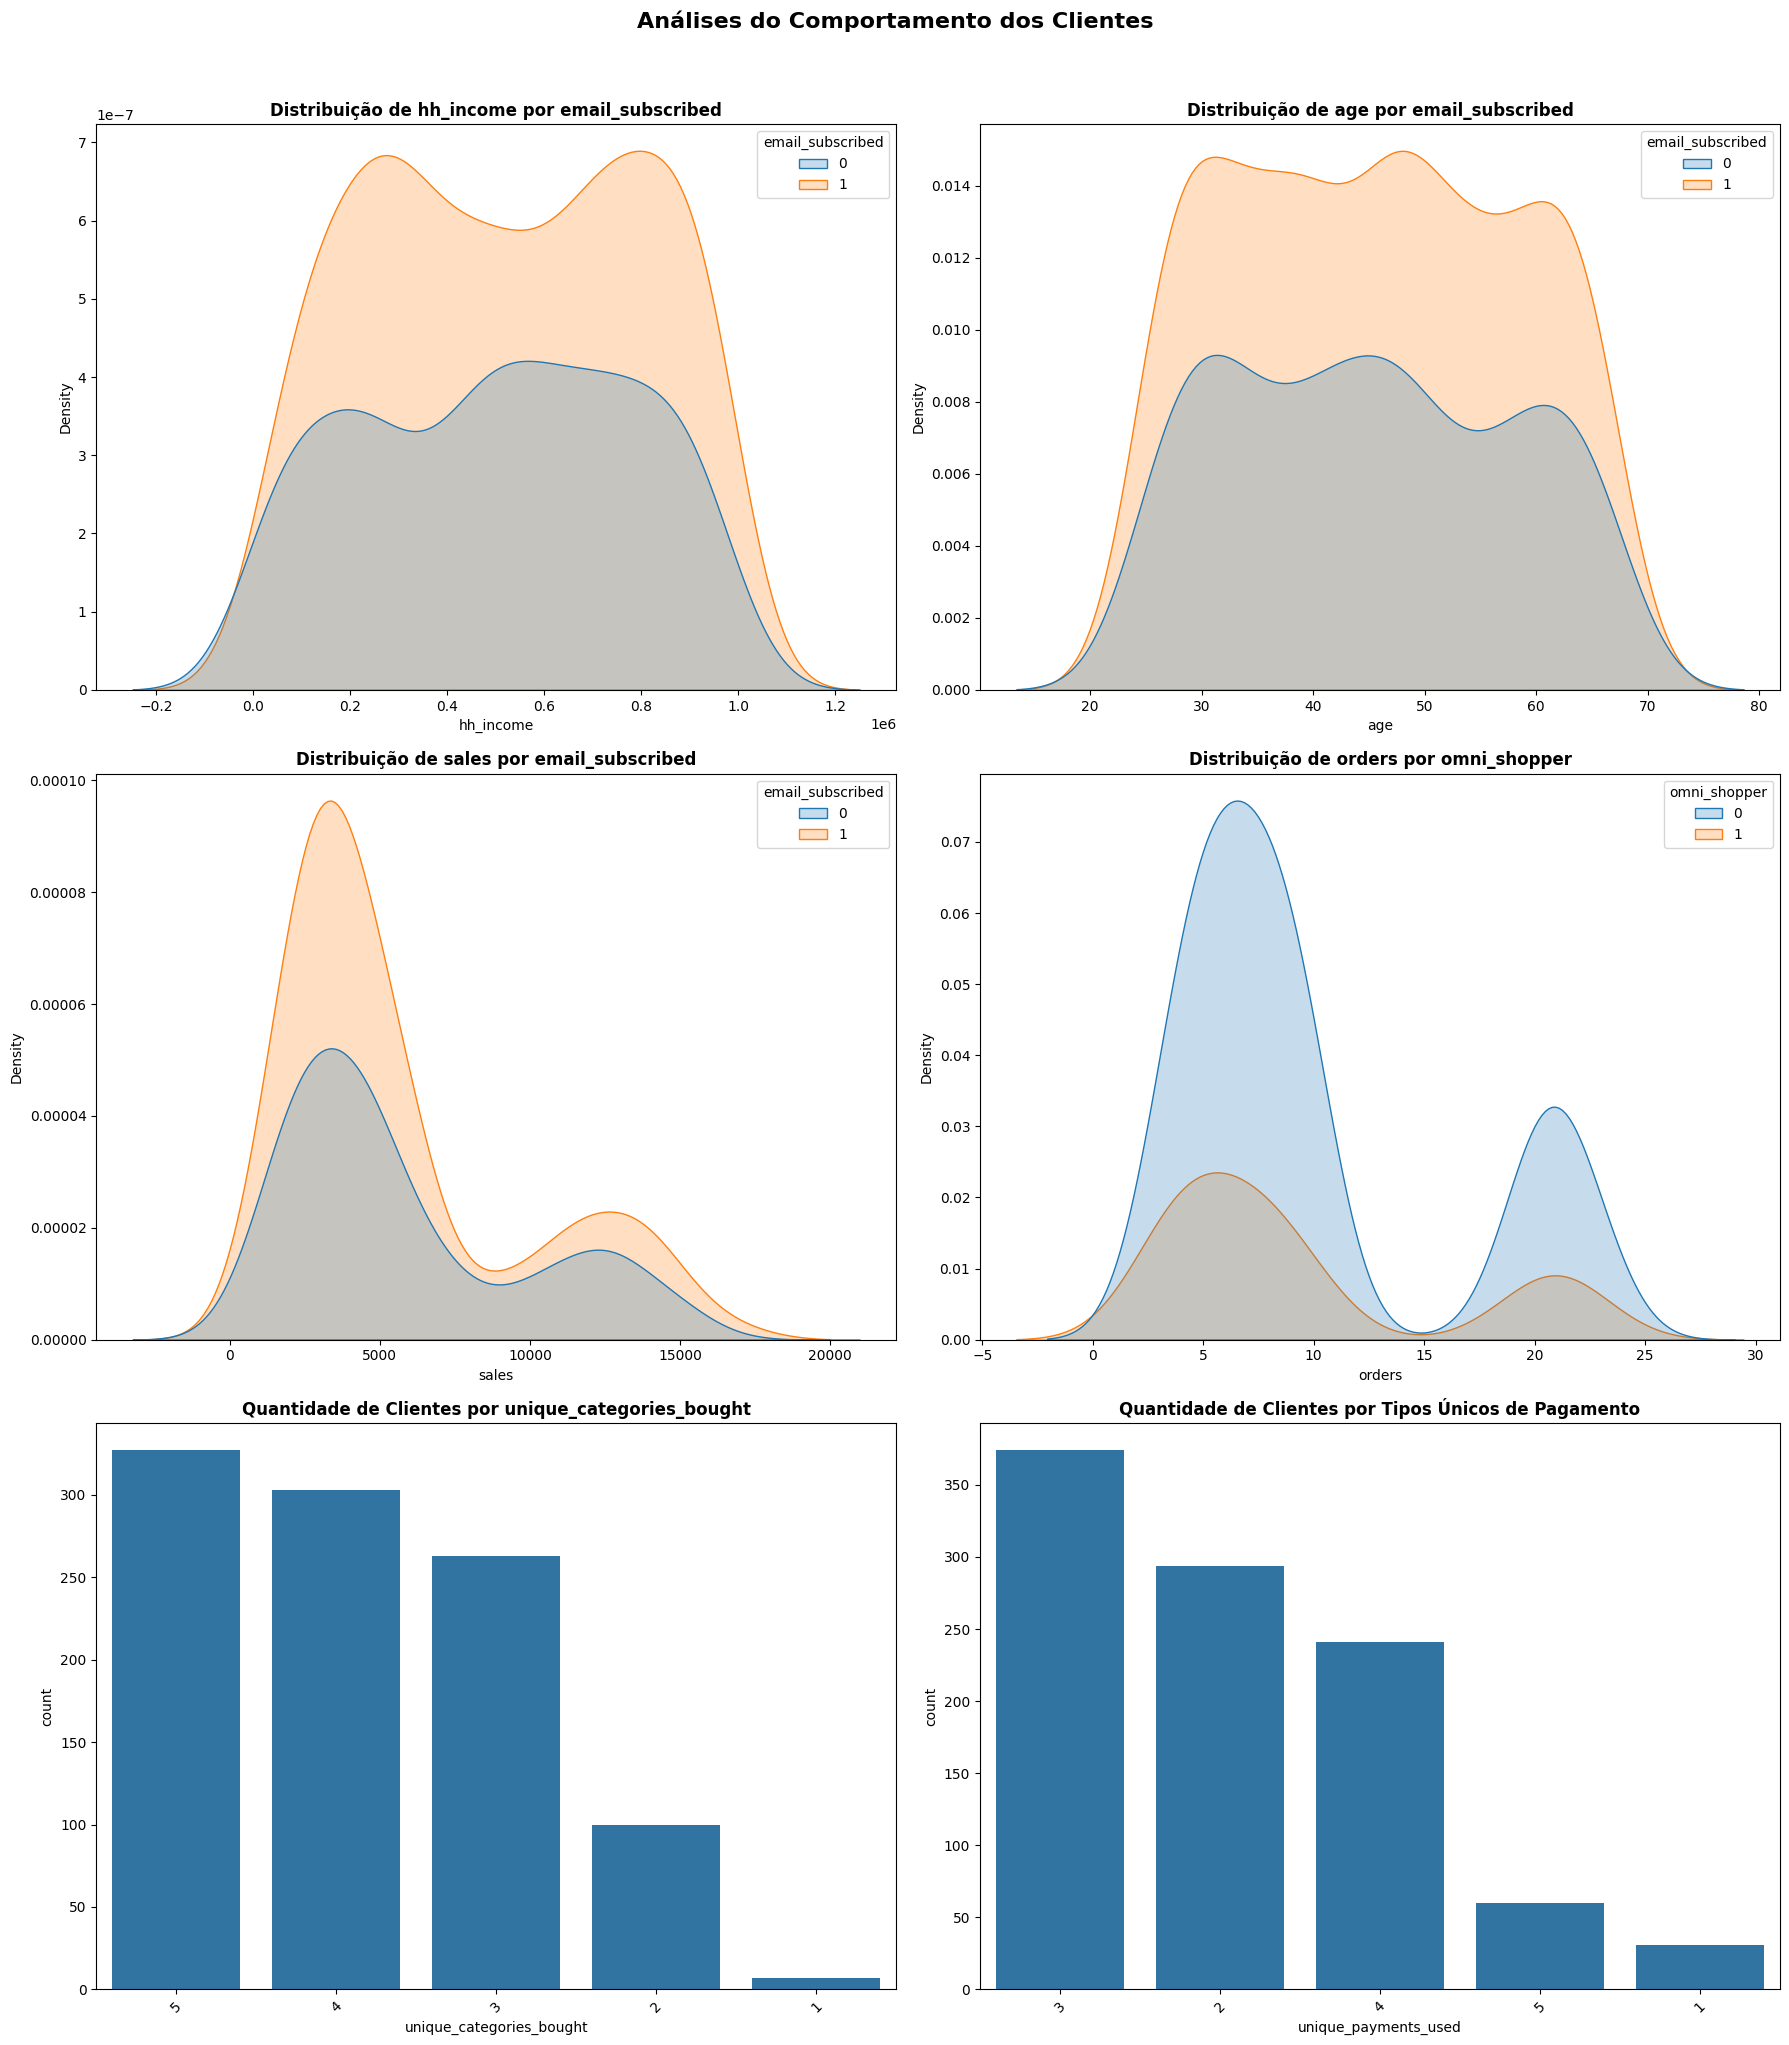

In [ ]:
#Ajuste do tamanho da figura
fig, axes = plt.subplots(3,2, figsize= (18,20))
fig.suptitle('Análises do Comportamento dos Clientes', fontsize=16, y=1.02, fontweight='bold')

# 1.Gráfico de Dispersão da renda por email_subscribed
sns.kdeplot(data=df3, x='hh_income', hue='email_subscribed', fill=True, ax=axes[0,0])
axes[0,0].set_title('Distribuição de hh_income por email_subscribed', fontweight='bold')

# 2.Gráfico de Dispersão da idade por email_subscribed
sns.kdeplot(data=df3, x='age', hue='email_subscribed', fill=True, ax=axes[0,1])
axes[0,1].set_title('Distribuição de age por email_subscribed', fontweight='bold')

# 3.Gráfico de Dispersão do gasto por email_subscribed
sns.kdeplot(data=df3, x='sales', hue='email_subscribed', fill=True, ax=axes[1,0])
axes[1,0].set_title('Distribuição de sales por email_subscribed', fontweight='bold')

# 4.Gráfico de Dispersão das ordens por omni_shopper
sns.kdeplot(data=df3, x='orders', hue='omni_shopper', fill=True, ax=axes[1,1])
axes[1,1].set_title('Distribuição de orders por omni_shopper', fontweight='bold')

# 5.Gráfico de barras: quantidade de clientes por unique_categories_bought
sns.countplot(data=df3, x='unique_categories_bought', order=df3['unique_categories_bought'].value_counts().index, ax=axes[2,0])
axes[2,0].set_title('Quantidade de Clientes por unique_categories_bought', fontweight='bold')
axes[2,0].tick_params(axis='x', rotation=45)

# 6.Gráfico de barras: quantidade de clientes por tipos únicos de pagamento
sns.countplot(data=df3, x='unique_payments_used', order=df3['unique_payments_used'].value_counts().index, ax=axes[2,1])
axes[2,1].set_title('Quantidade de Clientes por Tipos Únicos de Pagamento', fontweight='bold')
axes[2,1].tick_params(axis='x', rotation=45)

#Ajuste de layout
plt.tight_layout()
plt.show()

## 4.0 Modelagem dos Dados

In [72]:
df4 = df3.copy()

### 4.1 Data Filtering

In [73]:
df4.drop(columns = ['customer_id'], inplace = True)

### 4.2 Data Preparation

In [74]:
#Normalização Z-Score:

def normalizacao(df, col):
    mean_val = df[col].mean()
    std_val = df[col].std()
    df[col] = (df[col] - mean_val) / std_val
    return df

# Lista de colunas a normalizar
colunas_para_normalizar = ['aov', 'aur', 'upt']

# Aplicando a normalização
for coluna in colunas_para_normalizar:
    df4 = normalizacao(df4, coluna)

In [75]:
#Min Max Scaler:

scalers = {}

for col in df4[['sales', 'units', 'orders', 'unique_products_bought',
       'unique_payments_used', 'unique_categories_bought', 
       'age', 'hh_income']].columns:
    mm = MinMaxScaler()
    df4[col] = mm.fit_transform(df4[[col]])
    scalers[col] = mm

with open('../api/scaler/scalers.pkl', 'wb') as file:
    pickle.dump(scalers,file)

### 4.3 Estudo de Espaço

In [76]:
X = df4.copy()

#### 4.3.1 PCA

Text(0.5, 1.0, 'PCA - Importância dos Principais Componentes')

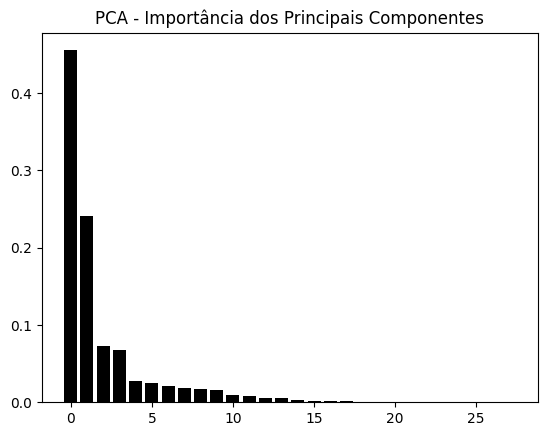

In [77]:
pca = dd.PCA(n_components = X.shape[1])

principal_components = pca.fit_transform(X)

features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color = 'black')
plt.title('PCA - Importância dos Principais Componentes')

In [20]:
#Selecionando apenas as 2 primeiras colunas (mais importantes):

pca = dd.PCA(n_components=2)
pca.fit(X)
pca_ds = pd.DataFrame(pca.transform(X), columns = (['col1', 'col2']))

pca_ds

,col1,col2
0,-0.848904,0.572359
1,0.966990,-0.382133
2,-1.294500,0.511774
3,0.028467,0.016796
4,-0.129484,1.801261
...,...,...
995,0.800547,-1.195599
996,-0.660246,-0.743781
997,0.350144,-1.051605
998,-0.734355,-0.647346


Text(0.5, 1.0, 'PCA')

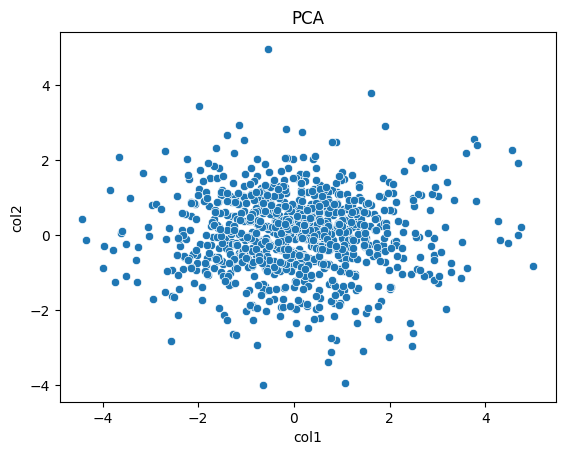

In [21]:
sns.scatterplot(x = 'col1', y = 'col2', data = pca_ds)
plt.title('PCA')

#### 4.3.2 T-SNE

In [22]:
reducer = mn.TSNE(n_components=2, n_jobs=1, random_state=42)
embedding = reducer.fit_transform(X)

df_tsne = pd.DataFrame(embedding)

Text(0.5, 1.0, 'T-SNE')

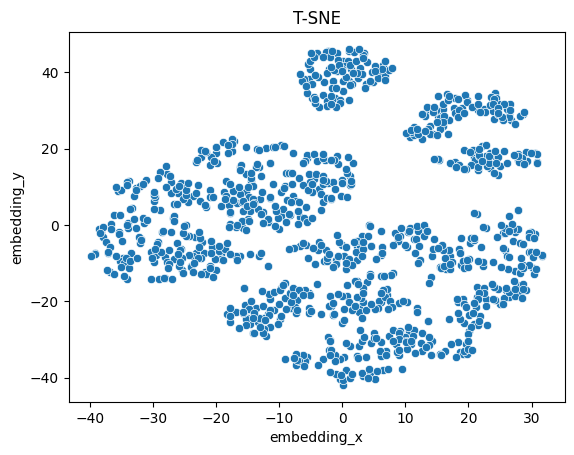

In [23]:
df_tsne = df_tsne.rename(columns = {0:'embedding_x', 1:'embedding_y'})

sns.scatterplot(x = 'embedding_x', y = 'embedding_y', data = df_tsne)
plt.title('T-SNE')

#### 4.3.3 UMAP

In [78]:
reducer = umap.UMAP(random_state=42, n_neighbors=8, min_dist=0.0, low_memory=True)
embedding = reducer.fit_transform(X)

df_umap = pd.DataFrame(embedding)
df_umap = df_umap.rename(columns={0:'embedding_x', 1:'embedding_y'})

c:\Users\samso\anaconda3\envs\projeto_cluster\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Text(0.5, 1.0, 'UMAP')

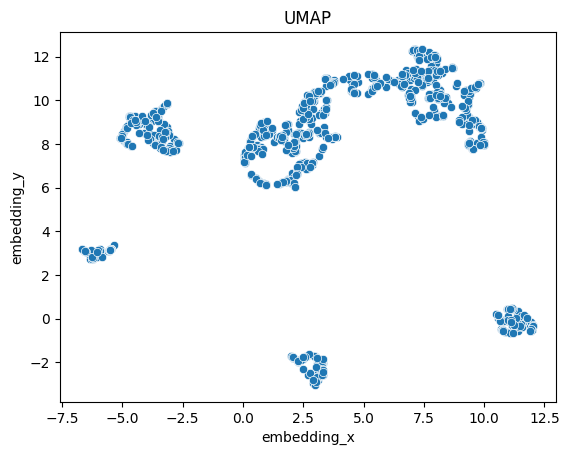

In [79]:
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_umap)
plt.title('UMAP')

## 5.0 Modelling

In [80]:
clusters = np.arange(2,50,1)
X_cluster = df_umap.copy()

### 5.1 KMEANS

In [81]:
kmeans_list = []

for k in clusters:
    kmeans_model  = c.KMeans(n_clusters=k)
    kmeans_model.fit(X_cluster)
    labels = kmeans_model.predict(X_cluster)
    sil = mt.silhouette_score(X_cluster, labels, metric='euclidean')
    kmeans_list.append(sil)

Text(0, 0.5, 'Silhouette Score')

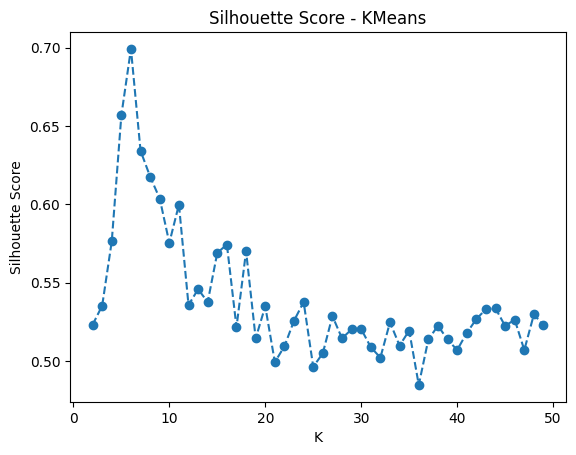

In [82]:
plt.plot(clusters, kmeans_list, linestyle='--', marker='o')
plt.title('Silhouette Score - KMeans')
plt.xlabel('K')
plt.ylabel('Silhouette Score')

Text(0.5, 1.0, 'KMeans - 6 clusters')

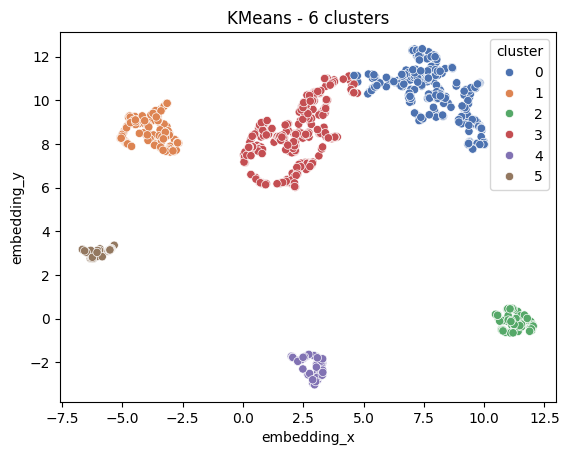

In [83]:
kmeans_model = c.KMeans(n_clusters=6)
kmeans_model.fit(X_cluster)
labels = kmeans_model.predict(X_cluster)
X_cluster['cluster'] = labels

sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', data = X_cluster, palette='deep')
plt.title('KMeans - 6 clusters')

### 5.2 GMM

In [84]:
gmm_list = []

for k in clusters:
    gmm_model  = mx.GaussianMixture(n_components=k)
    gmm_model.fit(X_cluster)
    labels = gmm_model.predict(X_cluster)
    sil = mt.silhouette_score(X_cluster, labels, metric='euclidean')
    gmm_list.append(sil)

Text(0, 0.5, 'Silhouette Score')

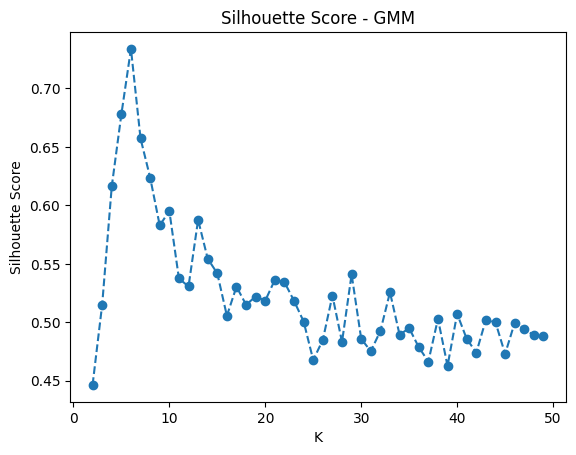

In [85]:
plt.plot(clusters, gmm_list, linestyle='--', marker='o')
plt.title('Silhouette Score - GMM')
plt.xlabel('K')
plt.ylabel('Silhouette Score')

## 6.0 Model Training

In [86]:
reducer = umap.UMAP(random_state=42, n_neighbors=8, min_dist=0.0, low_memory=True)
embedding = reducer.fit_transform(X)

with open('umap_reducer.pkl', 'wb') as f:
    pickle.dump(reducer, f)

c:\Users\samso\anaconda3\envs\projeto_cluster\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [87]:
with open('umap_reducer.pkl', 'rb') as f:
   umap_reducer =  pickle.load(f)

In [89]:
embedding_final = umap_reducer.transform(df4)
embedding_final = pd.DataFrame(embedding_final, columns=['embedding_x', 'embedding_y'])

gmm_model = mx.GaussianMixture(n_components=6)

gmm_model.fit(embedding_final)
labels = gmm_model.predict(embedding_final)

with open('../api/model/gmm_model.pkl', 'wb') as f:
    pickle.dump(gmm_model, f)

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

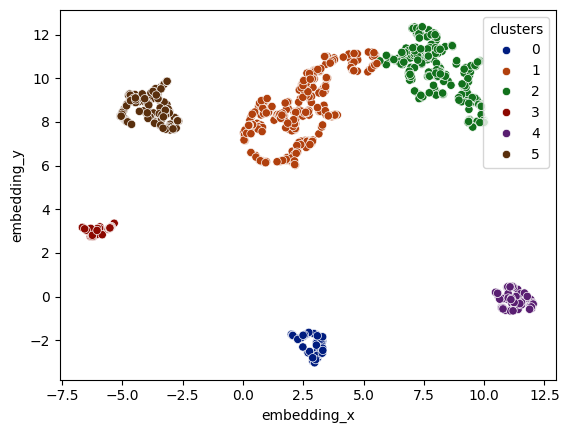

In [90]:
response = embedding_final.copy()
response['clusters'] = labels

sns.scatterplot(x='embedding_x', y='embedding_y', hue='clusters', data=response, palette='dark')

## 7.0 Cluster Profile

In [56]:
df7 = df3.copy()
df7['cluster'] = labels

In [57]:
df7.columns

Index(['customer_id', 'sales', 'units', 'orders', 'unique_products_bought',
       'unique_payments_used', 'unique_categories_bought', 'aov', 'aur', 'upt',
       'category_a_sales', 'category_b_sales', 'category_c_sales',
       'category_d_sales', 'category_e_sales', 'category_a_units',
       'category_b_units', 'category_c_units', 'category_d_units',
       'category_e_units', 'payment_cash', 'payment_credit', 'payment_debit',
       'payment_gc', 'payment_others', 'email_subscribed', 'omni_shopper',
       'age', 'hh_income', 'cluster'],
      dtype='object')

In [58]:
df_cluster = df7[['customer_id', 'cluster']].groupby('cluster').count().reset_index().rename(columns={'customer_id': 'qtde_clientes'})

df_year = df7[['age', 'cluster']].groupby('cluster').mean().reset_index()
df_income = df7[['hh_income', 'cluster']].groupby('cluster').mean().reset_index()
df_sales = df7[['sales', 'cluster']].groupby('cluster').mean().reset_index()
df_units = df7[['units', 'cluster']].groupby('cluster').mean().reset_index()
df_orders = df7[['orders', 'cluster']].groupby('cluster').mean().reset_index()
df_upb = df7[['unique_products_bought', 'cluster']].groupby('cluster').mean().reset_index()
df_upu = df7[['unique_payments_used', 'cluster']].groupby('cluster').mean().reset_index()
df_ucb = df7[['unique_categories_bought', 'cluster']].groupby('cluster').mean().reset_index()
df_aov = df7[['aov', 'cluster']].groupby('cluster').mean().reset_index()
df_aur = df7[['aur', 'cluster']].groupby('cluster').mean().reset_index()
df_utp = df7[['upt', 'cluster']].groupby('cluster').mean().reset_index()
df_cat_a_sales = df7[['category_a_sales', 'cluster']].groupby('cluster').mean().reset_index()
df_cat_b_sales = df7[['category_b_sales', 'cluster']].groupby('cluster').mean().reset_index()
df_cat_c_sales = df7[['category_c_sales', 'cluster']].groupby('cluster').mean().reset_index()
df_cat_d_sales = df7[['category_d_sales', 'cluster']].groupby('cluster').mean().reset_index()
df_cat_e_sales = df7[['category_e_sales', 'cluster']].groupby('cluster').mean().reset_index()
df_cat_a_units = df7[['category_a_units', 'cluster']].groupby('cluster').mean().reset_index()
df_cat_b_units = df7[['category_b_units', 'cluster']].groupby('cluster').mean().reset_index()
df_cat_c_units = df7[['category_c_units', 'cluster']].groupby('cluster').mean().reset_index()
df_cat_d_units = df7[['category_d_units', 'cluster']].groupby('cluster').mean().reset_index()
df_cat_e_units = df7[['category_e_units', 'cluster']].groupby('cluster').mean().reset_index()
df_p_cash = df7[['payment_cash', 'cluster']].groupby('cluster').mean().reset_index()
df_p_credit = df7[['payment_credit', 'cluster']].groupby('cluster').mean().reset_index()
df_p_debit = df7[['payment_debit', 'cluster']].groupby('cluster').mean().reset_index()
df_p_gc = df7[['payment_gc', 'cluster']].groupby('cluster').mean().reset_index()
df_p_others = df7[['payment_others', 'cluster']].groupby('cluster').mean().reset_index()
df_email = df7[['email_subscribed', 'cluster']].groupby('cluster').mean().reset_index()
df_omni_shopper = df7[['omni_shopper', 'cluster']].groupby('cluster').mean().reset_index()


In [59]:
# Lista com todos os DataFrames a serem mesclados
dfs_para_merge = [df_year, df_income, df_sales,
    df_units, df_orders, df_upb, df_upu, df_ucb,
    df_aov, df_aur, df_utp,
    df_cat_a_sales, df_cat_b_sales, df_cat_c_sales, df_cat_d_sales, df_cat_e_sales,
    df_cat_a_units, df_cat_b_units, df_cat_c_units, df_cat_d_units, df_cat_e_units,
    df_p_cash, df_p_credit, df_p_debit, df_p_gc, df_p_others,
    df_email, df_omni_shopper
]

# Realiza os merges sequencialmente
for df in dfs_para_merge:
    df_cluster = df_cluster.merge(df, how='inner', on='cluster')

In [60]:
df_cluster

,cluster,qtde_clientes,age,hh_income,sales,units,orders,unique_products_bought,unique_payments_used,unique_categories_bought,aov,aur,upt,category_a_sales,category_b_sales,category_c_sales,category_d_sales,category_e_sales,category_a_units,category_b_units,category_c_units,category_d_units,category_e_units,payment_cash,payment_credit,payment_debit,payment_gc,payment_others,email_subscribed,omni_shopper
0,0,247,45.287449,507469.635628,4182.388664,14.133603,6.506073,5.708502,2.676113,3.489879,636.706365,295.572680,2.152909,0.444277,0.062896,0.215642,0.253351,0.023834,0.353093,0.136162,0.229217,0.171982,0.109547,0.029195,0.555389,0.257879,0.132015,0.025521,0.060729,0.020243
1,1,157,44.796178,534050.955414,3586.401274,13.458599,6.445860,5.681529,2.834395,3.636943,555.429380,268.781103,2.087284,0.409525,0.102176,0.228589,0.230859,0.028851,0.303694,0.194825,0.231497,0.144290,0.125695,0.041617,0.543328,0.258444,0.124272,0.032340,1.000000,1.000000
2,2,173,45.728324,493063.583815,12336.734104,45.710983,20.947977,13.947977,3.982659,4.901734,590.023973,270.248299,2.185596,0.429370,0.083338,0.229349,0.228029,0.029914,0.313747,0.178484,0.236061,0.135133,0.136575,0.031262,0.540927,0.269054,0.126641,0.032116,0.473988,0.000000
3,3,266,46.199248,512793.233083,4044.830827,14.244361,6.699248,5.842105,2.740602,3.578947,610.927826,289.728053,2.122676,0.467618,0.083006,0.211984,0.213098,0.024295,0.367660,0.171471,0.217313,0.138569,0.104987,0.040151,0.539139,0.267247,0.128701,0.024762,1.000000,0.060150
4,4,103,43.145631,535378.640777,2224.077670,12.699029,6.388350,5.407767,2.679612,3.378641,331.095862,170.505135,1.968834,0.273567,0.234469,0.299623,0.073809,0.118531,0.159385,0.303526,0.209928,0.031240,0.295922,0.027815,0.515437,0.304848,0.127244,0.024657,0.485437,0.165049
5,5,54,44.759259,503814.814815,12440.648148,46.277778,20.888889,13.351852,3.796296,4.851852,595.994011,269.681456,2.216433,0.421216,0.093551,0.225577,0.229643,0.030014,0.311470,0.192085,0.224230,0.135311,0.136904,0.019045,0.546336,0.276700,0.125054,0.032865,1.000000,1.000000


## Relatório: Métricas e Perfil de Compra por Cluster de Clientes

In [67]:
products = pd.read_csv('../data/clustering_product.csv')

### Cluster 0:

- Quantidade de clientes: 247
- Idade média: 45,28
- Renda média: $ 507.469,63
- Email: poucos clientes, a maioria não
- Média de gasto na loja: $ 4.182,38
- Média de unidades compradas: 14,13
- Média de ordens: 6,50
- Média de gasto por pedido (AOV): 636.70
- Média do preço de cada item (AUR): 295.57
- Média de quantidade de itens por pedido (UPT): 2.15
- Categorias mais compradas: A, C e D
- Tipos de pagamentos mais usados: crédito, débito e gift card
- Omni Shopper: não

### Cluster 1:

- Quantidade de clientes: 157
- Idade média: 44,79
- Renda média: $ 534.050,95
- Email: sim
- Média de gasto na loja: $ 3.586,40
- Média de unidades compradas: 13.45
- Média de ordens: 6.44
- Média de gasto por pedido (AOV): 555.42
- Média do preço de cada item (AUR): 268.78
- Média de quantidade de itens por pedido (UPT): 2.08
- Categorias mais compradas: A, B e C
- Tipos de pagamentos mais usados: crédito, débito e gift card
- Omni Shopper: sim

### Cluster 2:

- Quantidade de clientes: 173
- Idade média: 45.72
- Renda média: $ 493.063,58
- Email: cerca da metade dos clientes cadastrou email
- Média de gasto na loja: $ 12.336,73
- Média de unidades compradas: 45.71
- Média de ordens: 20.94
- Média de gasto por pedido (AOV): 590.02
- Média do preço de cada item (AUR): 270.24
- Média de quantidade de itens por pedido (UPT): 2.18
- Categorias mais compradas: A, B, C, D e E
- Tipos de pagamentos mais usados: crédito, débito e gift card
- Omni Shopper: Não

### Cluster 3:

- Quantidade de clientes: 266
- Idade média: 46.19
- Renda média: $ 512.793,23
- Email: possui email cadastrado
- Média de gasto na loja: $ 4.044,83
- Média de unidades compradas: 14.24
- Média de ordens: 6.69
- Média de gasto por pedido (AOV): 610.92
- Média do preço de cada item (AUR): 289.72
- Média de quantidade de itens por pedido (UPT): 2.12
- Categorias mais compradas: A, B e C
- Tipos de pagamentos mais usados: crédito, débito e gift card
- Omni Shopper: alguns, não todos. A maioria não é omni shopper

### Cluster 4:

- Quantidade de clientes: 103
- Idade média: 43.14
- Renda média: $ 535.378,64
- Email: cerca da metade possui email cadastrado
- Média de gasto na loja: $ 2.224,07
- Média de unidades compradas: 12.69
- Média de ordens: 6.38
- Média de gasto por pedido (AOV): 331.09
- Média do preço de cada item (AUR): 170.50
- Média de quantidade de itens por pedido (UPT): 1.96
- Categorias mais compradas: B, C e E
- Tipos de pagamentos mais usados: crédito, débito e gift card
- Omni Shopper: alguns, não todos. A maioria não é onmi shopper.

### Cluster 5:

- Quantidade de clientes: 54
- Idade média: 44.75
- Renda média: $ 503.814,81
- Email: possuem email cadastrado
- Média de gasto na loja: $ 12.440,64
- Média de unidades compradas: 46.27
- Média de ordens: 20.88
- Média de gasto por pedido (AOV): 595.99
- Média do preço de cada item (AUR): 269.68
- Média de quantidade de itens por pedido (UPT): 2.21
- Categorias mais compradas: A, B, C, D e E
- Tipos de pagamentos mais usados: crédito, débito e gift card
- Omni Shopper: sim

## 8.0 Deploy

In [91]:
import json

scaler = pickle.load(open('../api/scaler/scalers.pkl', 'rb'))
umap_transformer = pickle.load(open('../api/reducer/umap_reducer.pkl', 'rb'))

In [103]:
def reduce_dimensionality(data):
    data = umap_transformer.transform(data)
    data = pd.DataFrame(data, columns = ['embedding_x', 'embedding_y'])
    return data

def normalizacao(df, col):
    mean_val = df[col].mean()
    std_val = df[col].std()
    df[col] = (df[col] - mean_val) / std_val
    return df

def preprocess_data(df2):
    
    # Lista de colunas a normalizar
    colunas_para_normalizar = ['aov', 'aur', 'upt']

    # Aplicando a normalização
    for coluna in colunas_para_normalizar:
        df2 = normalizacao(df2, coluna)
    
    for col in ['sales', 'units', 'orders', 'unique_products_bought', 'unique_payments_used', 'unique_categories_bought', 'age', 'hh_income']:
        df2[col] = scaler[col].transform(df2[[col]])
    
    df2 = df2[['sales', 'units', 'orders', 'unique_products_bought',
                'unique_payments_used', 'unique_categories_bought', 'aov', 'aur', 'upt',
                'category_a_sales', 'category_b_sales', 'category_c_sales',
                'category_d_sales', 'category_e_sales', 'category_a_units',
                'category_b_units', 'category_c_units', 'category_d_units',
                'category_e_units', 'payment_cash', 'payment_credit', 'payment_debit',
                'payment_gc', 'payment_others', 'email_subscribed', 'omni_shopper',
                'age', 'hh_income']]
    return df2

In [104]:
data_test = df_raw.head(2)
data_preprocess = preprocess_data(data_test)
data_reducer = reduce_dimensionality(data_preprocess)

C:\Users\samso\AppData\Local\Temp\ipykernel_35236\1796064331.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = (df[col] - mean_val) / std_val
C:\Users\samso\AppData\Local\Temp\ipykernel_35236\1796064331.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[col] = scaler[col].transform(df2[[col]])
C:\Users\samso\AppData\Local\Temp\ipykernel_35236\1796064331.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [107]:
data_reducer = data_reducer.astype(np.float64)
data_reducer

,embedding_x,embedding_y
0,6.879347,10.293457
1,-3.767333,8.015849


In [110]:
import pickle
import json

class CustomerClusteringModel:
    def __init__(self):
        with open('../api/model/gmm_model.pkl', 'rb') as file:
            self.gmm = pickle.load(file)
    
    def predict_cluster(self, data):
        clusters = self.gmm.predict(data)
        return json.dumps(clusters.tolist())

In [111]:
model = CustomerClusteringModel()

clusters_previstos = model.predict_cluster(data_reducer)

In [112]:
clusters_previstos

'[2, 5]'

## API - teste local

In [118]:
import json
import requests

#url = 'http://127.0.0.1:5000/empresa/predict'
url = 'https://responsible-libbie-samantasobral-6c1df9a7.koyeb.app/empresa/predict'
header = {'Content-type': 'application/json'}

data_predict = json.dumps(data_reducer.to_dict(orient='records'))

r = requests.post(url, data = str(data_predict), headers = header)

In [119]:
print('Status Code {}'.format(r.status_code))

Status Code 200


In [120]:
r.json()

[2, 5]